In [2]:
import sys
# Add the calibration folder path to the sys.path list
sys.path.append('../calibration')

from calibration import *
from tools import *
pd.set_option('display.float_format', lambda x: '%.5f' % x) # pickle_in = open("../data/cleaned_data","rb")
np.set_printoptions(precision=4, suppress=True)
import pickle

         0
0 34.98775


In [3]:
!tree ../data

../data
├── RAW
├── US_yieldCurve_interpolatedFunction
├── __pycache__
│   └── get_US_yieldCurve.cpython-37.pyc
├── cleaned_data
├── explore.ipynb
├── get_US_yieldCurve.py
├── optionm_SPX_1996-2019
├── optionm_SPX_1996-2019.zip
├── optionm_opprcd_SPX_1996-2017.csv
├── sp500index.csv
├── standopt.csv
├── standopt.zip
├── volsurf.csv
└── volsurf.zip

3 directories, 12 files


In [175]:
# # Local
# pickle_in = open("../data/cleaned_data","rb")
# data_raw = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("../data/US_yieldCurve_interpolatedFunction","rb")
# yieldCurve = pickle.load(pickle_in)
# pickle_in.close()

# Download from HU box
!wget https://box.hu-berlin.de/f/7e9fe82306824965a393/?dl=1 -O cleaned_data
pickle_in = open("./cleaned_data","rb")
data_raw = pickle.load(pickle_in)
pickle_in.close()


!wget https://box.hu-berlin.de/f/d307410a63a9436eaf63/?dl=1 -O US_yieldCurve_interpolatedFunction
pickle_in = open("./US_yieldCurve_interpolatedFunction","rb")
yieldCurve = pickle.load(pickle_in)
pickle_in.close()

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


FileNotFoundError: [Errno 2] No such file or directory: './cleaned_data'

## Check if the Heston Pricing Code
The Heston pricing code in this project should match with the calibration reuslt in the Mayer paper provided by Prof. Packham.

In [13]:
parameters_name = ['spot vol', 'mean reversion', 'long term mean of vol', 'correclation', 'vol of vol']

print('Parameters in Mayer paper:')

for i in list(zip(parameters_name, par_1)):
    print(i[0]+":", i[1])

Parameters in Mayer paper:
spot vol: 0.013681
mean reversion: 1.605179
long term mean of vol: 0.053318
correclation: -0.6201
vol of vol: 0.590506


In [133]:
HS_price = call_price_HS(0.75, BS_price_1.S, BS_price_1.K, BS_price_1.Tau,0,par_1)

In [134]:
result = pd.concat([BS_price_1, HS_price], axis=1)
result.columns = ['Tau', 'K', 'BS_price', 'S', 'r', 'HS_price']

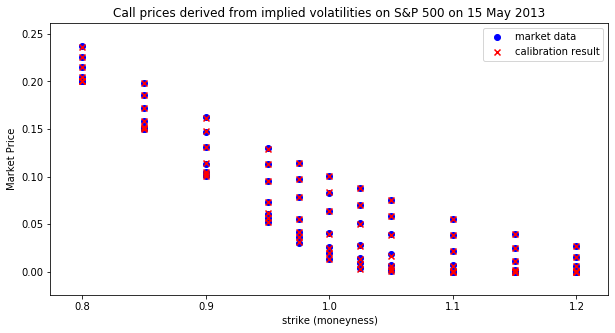

In [135]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.scatter(result['K'], 
           result['BS_price'], marker='o', color='b', label = 'market data')

ax.scatter(result['K'], 
           result['HS_price'], marker='x', color='r', label = 'calibration result')

ax.set(xlabel='strike (moneyness)', ylabel='Market Price', 
       title='Call prices derived from implied volatilities on S&P 500 on 15 May 2013')

ax.legend()

The code works fine. (At least same to Mayer paper)

## Calibrate on Real Option Data
- We calibrate on 20130515's call option data
- The target is the mid price

In [18]:
# Slice data
date_string = '20130515'
data = slice_data(data_raw, date=date_string)
data = data.iloc[:,:-4] # Remove unwanted columns

In [19]:
# Get the coresponding interest rate by yield curve (detail please see get_yield_curve.ipynb)
data.loc[:,'yield'] = data.t2m.apply(lambda x: yieldCurve[date_string](x))

In [41]:
data.head()

,date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,t2m,Adj Close,yield
4288037,20130515,C,1600000,57.40000,60.00000,21364,0.23389,0.00822,1658.78003,0.00080
4288042,20130515,C,1625000,32.80000,35.40000,6920,0.23621,0.00822,1658.78003,0.00080
4288043,20130515,C,1630000,28.00000,30.60000,1594,0.22651,0.00822,1658.78003,0.00080
4288044,20130515,C,1635000,23.40000,25.80000,4512,0.21669,0.00822,1658.78003,0.00080
4288045,20130515,C,1640000,19.20000,21.00000,2480,0.20929,0.00822,1658.78003,0.00080


In [20]:
# Mid Price 
mid_price = (data.best_offer + data.best_bid)/2

In [45]:
# Define loss function
def lossfunction(par, target_price, S, K, Tau, r, volume):
    v0, kappa, theta, rho, vol_vol = par
    
    # Give large loss to parameters that out of range
    if v0 < 0.0  or \
       kappa < 0.0 or \
       theta < 0.0 or \
       rho < -1.0 or \
       rho > 1.0 or \
       vol_vol < 0.0 :
#         print('parameters hit bound')
        return 500000.0


    # Feller Condition, comment out at this moment because Mayer's result does not follow
#     if 2 * kappa * theta <= vol_vol ** 2: 
#         print('Fella')
#         return 5000.0
    
    # Apply weight 
    weight_volume = volume/np.sum(volume)

    # Calculate Heston price
    HS_price = call_price_HS(0.75, S, K, Tau, r, par)

    # Absolute difference in percentage weighted by trading volume
    loss = np.sum(np.abs((target_price - HS_price)/target_price)* weight_volume) 

    return loss

In [23]:
weight_volume = data.volume/np.sum(data.volume)

In [46]:
# Loss of using Mayer paper's calibration result to price real world data
Mayer_realOption_loss = lossfunction(par_1, mid_price,
             data.loc[:,'Adj Close'],
             data.loc[:,'strike_price']/1000,
             data.loc[:,'t2m'],
             data.loc[:,'yield'], 
             data.volume)

print("Loss of using Mayer paper's calibration result to price real world data",Mayer_realOption_loss)

Loss of using Mayer paper's calibration result to price real world data 0.4454806093944067


## Optimize with zero interest rate
- The reason of calibrating Heston model with zero interest rate is that it is also used in Mayer paper 
- Calibration with interest rate according US yield curve is in the next session

In [47]:
lossfunction2opt = partial(lossfunction, target_price = mid_price,
                           S=data.loc[:,'Adj Close'],
                           K=data.loc[:,'strike_price']/1000,
                           Tau=data.loc[:,'t2m'],
                           r=0, # 0 risk free rate
#                            r=data.loc[:,'yield'], # With risk free rate according to yield curve
                           volume=data.volume)

In [59]:
# Use brute force to find a good starting simplex for the later Nelder-Mead simplex algorithm
p0 = brute(lossfunction2opt,
           (
               (0.01, 0.031, 0.01),    # v0
               (2.5, 10.6, 5.0),  # kappa
               (0.01, 0.041, 0.01),  # theta
               (-0.75, 0.01, 0.25),  # rho
               (0.05, 0.251, 0.1)  # vol_vol
           ), 
           finish=None)

In [61]:
# Gloabl Min
p0

array([ 0.01,  2.5 ,  0.02, -0.5 ,  0.05])

In [62]:
# p0 = np.array([ 0.01,  2.5 ,  0.02, -0.5,  0.25]) # v0, kappa, theta, rho, vol_vol 
# p0 = par_1 # From Mayer Paper
opt = fmin(lossfunction2opt, p0,
           xtol=0.000001, ftol=0.000001,
           maxiter=750, maxfun=900)

In [63]:
# v0, kappa, theta, rho, vol_vol = par
print(opt)

[ 0.0082  7.3984  0.0172 -0.7308  0.0548]


In [64]:
print(np.array(par_1))

[ 0.0137  1.6052  0.0533 -0.6201  0.5905]


In [86]:
# Loss of this calibration result to price real world data
loss_1 = lossfunction(opt, mid_price,
             data.loc[:,'Adj Close'],
             data.loc[:,'strike_price']/1000,
             data.loc[:,'t2m'],
             0,
#              data.loc[:,'yield'], 
             data.volume)
print(round(loss_1,4))

0.0735


In [87]:
# Loss of using Mayer paper's calibration result to price real world data
loss_2 = lossfunction(par_1, mid_price,
             data.loc[:,'Adj Close'],
             data.loc[:,'strike_price']/1000,
             data.loc[:,'t2m'],
             0,
#              data.loc[:,'yield'], 
             data.volume)
print(round(loss_2,4))

0.1834


In [66]:
# Option price with this calibration result
HS_price_1 = call_price_HS(0.75, 
                         data.loc[:,'Adj Close'],
                         data.loc[:,'strike_price']/1000,
                         data.loc[:,'t2m'],
                         0,
#                          data.loc[:,'yield'],
                         opt)

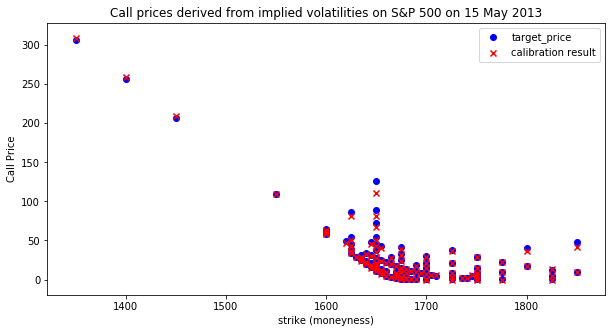

In [71]:
plot_result(data.loc[:,'strike_price']/1000, HS_price=HS_price_1, target_price=mid_price)

In [72]:
# Option price with Mayer paper calibration result
HS_price_2 = call_price_HS(0.75, 
                         data.loc[:,'Adj Close'],
                         data.loc[:,'strike_price']/1000,
                         data.loc[:,'t2m'],
                         0,
#                          data.loc[:,'yield'],
                           par_1) 

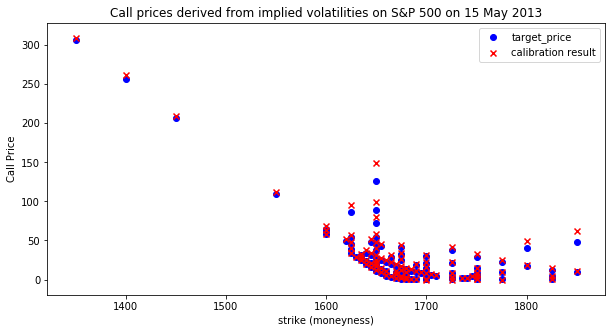

In [73]:
plot_result(data.loc[:,'strike_price']/1000, HS_price=HS_price_2, target_price=mid_price)

## Optimize with interest rate from US yield curve
- Interest rate is obtained from interpolation of US yield curve. Detail please see get_yield_curve.ipynb

In [75]:
lossfunction2opt = partial(lossfunction, target_price = mid_price,
                           S=data.loc[:,'Adj Close'],
                           K=data.loc[:,'strike_price']/1000,
                           Tau=data.loc[:,'t2m'],
#                            r=0, # 0 risk free rate
                           r=data.loc[:,'yield'], # With risk free rate according to yield curve
                           volume=data.volume)

In [77]:
p0_withInterest = brute(lossfunction2opt,
           (
               (0.01, 0.031, 0.01),    # v0
               (2.5, 10.6, 5.0),  # kappa
               (0.01, 0.041, 0.01),  # theta
               (-0.75, 0.01, 0.25),  # rho
               (0.05, 0.251, 0.1)  # vol_vol
           ), 
           finish=None)

In [78]:
# Gloabl Min
p0_withInterest

array([ 0.01,  2.5 ,  0.01, -0.25,  0.25])

In [79]:
opt_withInterest = fmin(lossfunction2opt, p0_withInterest,
           xtol=0.000001, ftol=0.000001,
           maxiter=750, maxfun=900)

In [88]:
# Loss of this calibration result to price real world data
loss_3 = lossfunction(opt_withInterest, mid_price,
             data.loc[:,'Adj Close'],
             data.loc[:,'strike_price']/1000,
             data.loc[:,'t2m'],
#              0,
             data.loc[:,'yield'], 
             data.volume)
print(round(loss_3,4))

0.1692


In [89]:
# Loss of using Mayer paper's calibration result to price real world data
loss_4 = lossfunction(par_1, mid_price,
             data.loc[:,'Adj Close'],
             data.loc[:,'strike_price']/1000,
             data.loc[:,'t2m'],
#              0,
             data.loc[:,'yield'], 
             data.volume)
print(round(loss_4,4))

0.4455


In [81]:
# Option price with this calibration result
HS_price_3 = call_price_HS(0.75, 
                         data.loc[:,'Adj Close'],
                         data.loc[:,'strike_price']/1000,
                         data.loc[:,'t2m'],
#                          0,
                         data.loc[:,'yield'],
                         opt_withInterest)

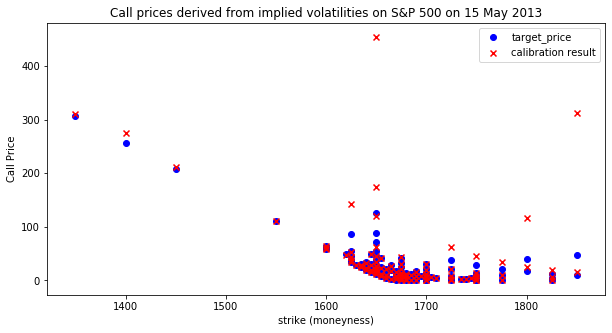

In [82]:
plot_result(data.loc[:,'strike_price']/1000, HS_price=HS_price_3, target_price=mid_price)

In [142]:
# Option price with Mayer paper calibration result
HS_price_4 = call_price_HS(0.75, 
                         data.loc[:,'Adj Close'],
                         data.loc[:,'strike_price']/1000,
                         data.loc[:,'t2m'],
#                          0,
                         data.loc[:,'yield'],
                           par_1) 

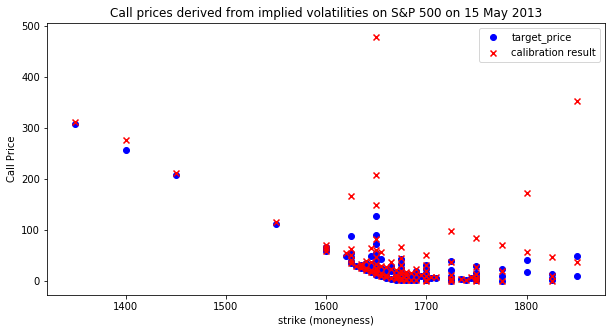

In [143]:
plot_result(data.loc[:,'strike_price']/1000, HS_price=HS_price_4, target_price=mid_price)

## Compare to the data used by Mayer paper
- The data used by Mayer paper is from Bloomberg volatility surface.
- The volatility surface is normalised to spot price = 1. 
- We plug the optimization result without interest rate to the call price function so to see if the calibration result calibrated to real data match with the normalised data. 

In [144]:
HS_price_0 = call_price_HS(0.75, BS_price_1.S, BS_price_1.K, BS_price_1.Tau,0,opt)

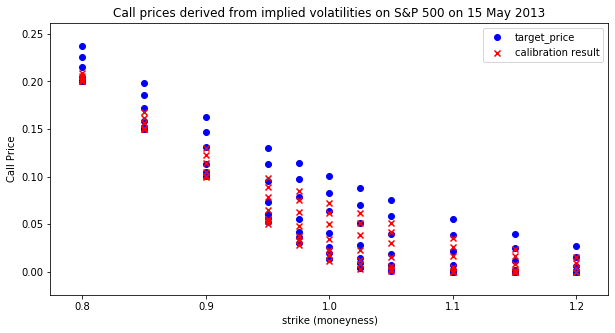

In [145]:
plot_result(result.K, HS_price=HS_price_0, target_price=result.BS_price)

In [157]:
result.BS_price[result.BS_price == 0] = 0.0001

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [158]:
loss_0 = lossfunction(opt,
                      result.BS_price,
                      BS_price_1.S,
                      BS_price_1.K, 
                      BS_price_1.Tau,
                      0,
                      1)
print(round(loss_0,4))

407780.4828


## Conclusion
1. Interest Rate obtained by interpolation of US yield curve cannot improve loss in this calibration setting 
2. This NB's calibration results do not agree with the calibration result in Mayer paper, especially in kappa and theta. 

In [163]:
result = pd.DataFrame(zip(['With Interest Rate']+par_names+['Absolute Loss '],
                 ['No']+list(opt)+[loss_1],
                 ['No']+list(par_1)+[loss_2],
                 ['Yes']+list(opt_withInterest)+[loss_3], 
                 ['Yes']+list(par_1)+[loss_4]))#, zip(par_names, par_1))
result.set_index(0, drop=True, inplace=True)
result.columns = ['NB Result', 'Mayer Paper Result','NB Result', 'Mayer Paper Result' ]

In [164]:
result

,NB Result,Mayer Paper Result,NB Result,Mayer Paper Result
0,,,,
With Interest Rate,No,No,Yes,Yes
v0,0.00818,0.01368,0.01011,0.01368
kappa,7.39842,1.60518,0.00598,1.60518
theta,0.01716,0.05332,0.00995,0.05332
rho,-0.73084,-0.62010,-0.12359,-0.62010
vol_vol,0.05482,0.59051,0.39468,0.59051
Absolute Loss,0.07353,0.18337,0.16924,0.44548


## Other stuffs

In [34]:
toprint = pd.concat([HS_price_2 ,mid_price, data.volume, data.t2m, data.loc[:,'yield']], axis=1)
print(toprint)

         strike_price         0  volume     t2m   yield
4288037      58.79201  58.70000   21364 0.00822 0.00080
4288042      33.90286  34.10000    6920 0.00822 0.00080
4288043      29.02562  29.30000    1594 0.00822 0.00080
4288044      24.25980  24.60000    4512 0.00822 0.00080
4288045      19.68136  20.10000    2480 0.00822 0.00080
4288046      15.39447  15.85000    7511 0.00822 0.00080
4288047      11.52374  11.55000   26907 0.00822 0.00080
4288048       8.19309   8.10000    8012 0.00822 0.00080
4288049       5.49404   4.90000   37447 0.00822 0.00080
4288050       3.45548   2.70000   18449 0.00822 0.00080
4288051       2.03137   1.45000   29801 0.00822 0.00080
4288052       1.11494   0.80000   17157 0.00822 0.00080
4288053       0.57196   0.52500    9966 0.00822 0.00080
4288054       0.27500   0.27500    7644 0.00822 0.00080
4288055       0.12440   0.15000     978 0.00822 0.00080
4288057       0.02158   0.10000    6546 0.00822 0.00080
4288062       0.00013   0.05000    1741 0.00822 

In [35]:
ordering = (np.abs(HS_price_2 - mid_price) / mid_price).sort_values(ascending=False)

In [36]:
toprint.loc[ordering.index,:]

,strike_price,0,volume,t2m,yield
4289925,305.27245,47.50000,2000,1.60000,0.19312
4289917,449.77762,125.70000,1152,1.60000,0.19312
4289803,106.79474,40.05000,3503,1.10137,0.12692
4288062,0.00013,0.05000,1741,0.00822,0.00080
4290729,0.00104,0.05000,953,0.02466,0.00252
4289674,169.82879,88.40000,2245,0.85205,0.11445
4288057,0.02158,0.10000,6546,0.00822,0.00080
4289408,117.06605,72.40000,2717,0.60274,0.10222
4289407,138.92975,86.95000,3103,0.60274,0.10222
4290892,0.14490,0.35000,2364,0.04384,0.00475


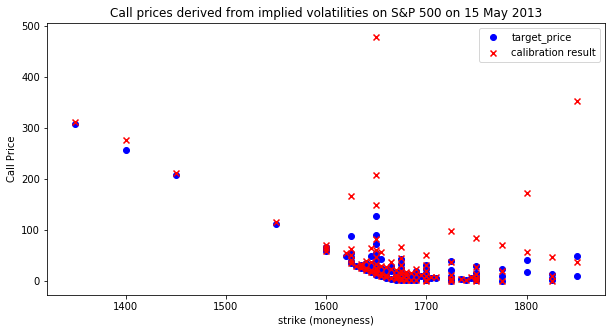

In [38]:
plot_result(data.loc[:,'strike_price']/1000, HS_price=HS_price_3, target_price=mid_price)

In [39]:
par_names = ['v0', 'kappa', 'theta', 'rho', 'vol_vol']

print('calibration result Francis')
for i in zip(par_names, opt):
    print(i)

calibration result Francis
('v0', 0.010552029994750644)
('kappa', 1.1995843787448408)
('theta', 7.443154024401304e-09)
('rho', -0.15087874133443124)
('vol_vol', 0.5542626192409404)


In [40]:
print('calibration result Mayer')
for i in zip(par_names, par_1):
    print(i)

calibration result Mayer
('v0', 0.013681)
('kappa', 1.605179)
('theta', 0.053318)
('rho', -0.6201)
('vol_vol', 0.590506)
